# Project Based Internship: Data Scientist - Home Credit Indonesia x Rakamin Academy
Nama: An Naffila Putri Prasari

# Problem Research

Home Credit Indonesia wants to use various statistical methods and Machine Learning to create a prediction model. The model is expected to ensure that customers who are able to make repayments are not rejected when applying for a loan.

# Import Library

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

raw_train = pd.read_csv('/content/gdrive/My Drive/Project Based Internship Rakamin Academy/Data Scientist - Home Credit Indonesia/application_train.csv')
raw_test = pd.read_csv('/content/gdrive/My Drive/Project Based Internship Rakamin Academy/Data Scientist - Home Credit Indonesia/application_test.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# set_options to show all columns
pd.set_option('display.max.columns', None)

In [4]:
# show data
raw_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
print('This dataset has %d rows dan %d columns.\n' % raw_train.shape)

This dataset has 307511 rows dan 122 columns.



# Data Visualization and Business Insight

## Number of customers who applied for a loan

In [6]:
number_of_customers = raw_train.groupby('TARGET')['CODE_GENDER'].count().reset_index()
number_of_customers.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace = True)

number_of_customers['Percentages'] = round(number_of_customers.Customers / number_of_customers.Customers.sum(), 2)
number_of_customers

,TARGET,Customers,Percentages
0,0,282686,0.92
1,1,24825,0.08


From the table above, it can be seen that 92% of customers do not have problems in payment and the other 8% have problems in payment.

## Contract types


In [7]:
contract_type = raw_train.groupby(['TARGET', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by = 'NAME_CONTRACT_TYPE')
contract_type.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

name_of_contract_type = list(contract_type['NAME_CONTRACT_TYPE'].unique())
percentage = []

for i in name_of_contract_type:
    data = contract_type[contract_type['NAME_CONTRACT_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

contract_type['Percentage'] = percentage
contract_type

,TARGET,NAME_CONTRACT_TYPE,Customers,Percentage
0,0,Cash loans,255011,0.92
2,1,Cash loans,23221,0.08
1,0,Revolving loans,27675,0.95
3,1,Revolving loans,1604,0.05


From the table above, customers tend to choose cash loans as their preferred contract type. The percentage of customers who have payment problems in both types of contracts is similar.

## Income types

In [8]:
income_type = raw_train.groupby(['TARGET', 'NAME_INCOME_TYPE'])['CODE_GENDER'].count().reset_index().sort_values('NAME_INCOME_TYPE').reset_index()
income_type.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
income_type.drop(columns = 'index', inplace=True)

income_type_list = list(income_type['NAME_INCOME_TYPE'].unique())
percentage = []

for i in income_type_list:
    data = income_type[income_type.NAME_INCOME_TYPE == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

income_type['Percentage'] = percentage
income_type

,TARGET,NAME_INCOME_TYPE,Customers,Percentage
0,0,Businessman,10,1.00
1,0,Commercial associate,66257,0.93
2,1,Commercial associate,5360,0.07
3,0,Maternity leave,3,0.60
4,1,Maternity leave,2,0.40
5,0,Pensioner,52380,0.95
6,1,Pensioner,2982,0.05
7,0,State servant,20454,0.94
8,1,State servant,1249,0.06
9,0,Student,18,1.00


## Marital status

In [9]:
raw_train.NAME_FAMILY_STATUS.value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

From the results above, there are 6 categories for marital status. Furthermore, it will be simplified into two categories, being married and unmarried.
* married = people who have a partner
* unmarried = people who not have a partner or have had a partner


In [10]:
marital_status = []
married = ['Married', 'Civil marriage']

for i in raw_train.NAME_FAMILY_STATUS:
    if i in married:
        marital_status.append('Married')
    else:
        marital_status.append('Unmarried')

raw_train['Marital_status'] = marital_status
raw_train.drop(columns= 'NAME_FAMILY_STATUS', inplace=True)

In [11]:
status_marital = raw_train.groupby(['TARGET', 'Marital_status'])['CODE_GENDER'].count().reset_index()
status_marital.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

status_marital_list = list(status_marital['Marital_status'].unique())
percentage = []
for i in status_marital_list:
    data = status_marital[status_marital.Marital_status == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

status_marital['Percentage'] = percentage
status_marital

,TARGET,Marital_status,Customers,Percentage
0,0,Married,208396,0.92
1,0,Unmarried,74290,0.08
2,1,Married,17811,0.91
3,1,Unmarried,7014,0.09


There is no significant difference in marital status because the number of loan applications received between the two categories (married and unmarried) has the similar value.

## Age

DAYS_BIRTH column which contains data on the difference between today and the customer's birthday will be used to determine the customer's age.

In [12]:
raw_train['Age'] = np.floor(raw_train['DAYS_BIRTH'] / -365).astype(int)
raw_train.drop(columns= 'DAYS_BIRTH', inplace=True)

In [13]:
# make category age
age_cat = []
for i in raw_train['Age']:
    if i < 36:
        age_cat.append('Young Adult')
    elif i < 51:
        age_cat.append('Adult')
    else:
        age_cat.append('Older')

raw_train['Age_category'] = age_cat

In [14]:
group_age = raw_train.groupby(['TARGET', 'Age_category'])['CODE_GENDER'].count().reset_index().sort_values('Age_category').reset_index()
group_age.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
group_age.drop(columns = 'index', inplace=True)

name_of_age = list(group_age['Age_category'].unique())
percentage = []

for i in name_of_age:
    data = group_age[group_age['Age_category'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

group_age['Percentage'] = percentage

mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}

group_age['TARGET'] = group_age['TARGET'].map(mapping_target)
group_age

,TARGET,Age_category,Customers,Percentage
0,Dont Have Problem,Adult,108678,0.92
1,Have Problem,Adult,9403,0.08
2,Dont Have Problem,Older,91718,0.94
3,Have Problem,Older,5469,0.06
4,Dont Have Problem,Young Adult,82290,0.89
5,Have Problem,Young Adult,9953,0.11


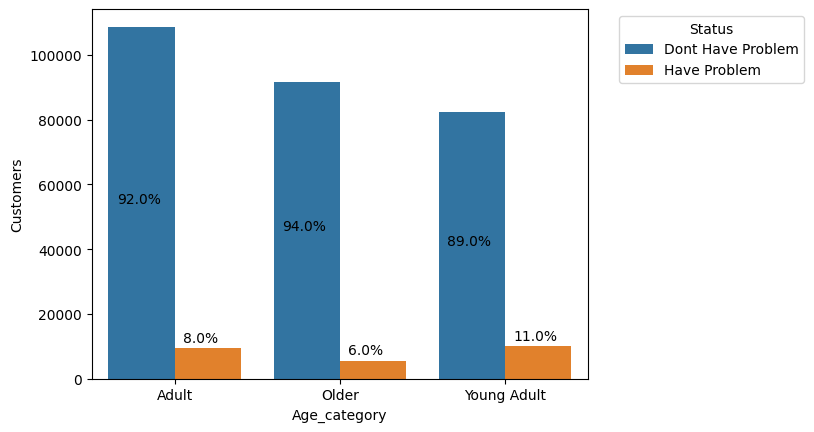

In [15]:
# Visualize group of age
ax = sns.barplot(x = 'Age_category', y= 'Customers', hue= group_age.TARGET, data = group_age)
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

for i, v in enumerate(group_age['Customers']):
    if i%2 == 0:
        plt.text(i/2 - 0.35, v/2, s= str(group_age['Percentage'][i]* 100) + '%', color='black')
    else:
        plt.text(i/2 - 0.45, v + 2000, s= str(group_age['Percentage'][i] * 100) + '%', color='black')

plt.show(ax)

From the chart above, it can be seen that the Adult age category (36-50 y.o) has the most loan applications with no repayment issues (92%), so Home Credit Indonesia can target the Adult category for loans.

## Occupation types

In [16]:
occupation_type = raw_train.groupby(['TARGET', 'OCCUPATION_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by=['OCCUPATION_TYPE', 'TARGET'])
occupation_type.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

occupation_type_name = list(occupation_type['OCCUPATION_TYPE'].unique())
percentage = []

for i in occupation_type_name:
    data = occupation_type[occupation_type['OCCUPATION_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

occupation_type['Percentage'] = percentage
occupation_type

,TARGET,OCCUPATION_TYPE,Customers,Percentage
0,0,Accountants,9339,0.95
18,1,Accountants,474,0.05
1,0,Cleaning staff,4206,0.90
19,1,Cleaning staff,447,0.10
2,0,Cooking staff,5325,0.90
20,1,Cooking staff,621,0.10
3,0,Core staff,25832,0.94
21,1,Core staff,1738,0.06
4,0,Drivers,16496,0.89
22,1,Drivers,2107,0.11


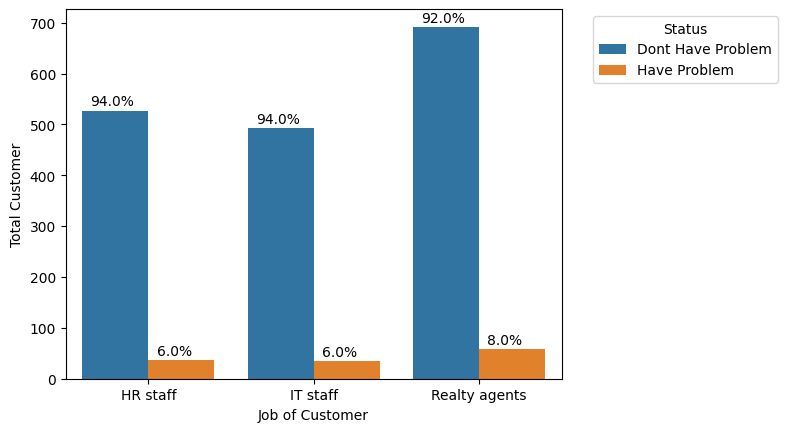

In [17]:
occupation_type_low = occupation_type[occupation_type['OCCUPATION_TYPE'].isin(['HR staff', 'IT staff', 'Realty agents'])]
occupation_type_low = occupation_type_low.reset_index()
occupation_type_low.drop(columns = 'index', inplace=True)

mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}

occupation_type_low['TARGET'] = occupation_type_low['TARGET'].map(mapping_target)


ax = sns.barplot(x = 'OCCUPATION_TYPE', y= 'Customers', hue= 'TARGET', data = occupation_type_low)
plt.xlabel('Job of Customer')
plt.ylabel('Total Customer')
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

for i, v in enumerate(occupation_type_low['Customers']):
    if i%2 == 0:
        plt.text(i/2 - 0.35, v + 10, s= str(occupation_type_low['Percentage'][i]* 100) + '%', color='black')
    else:
        plt.text(i/2 - 0.45, v + 10, s= str(occupation_type_low['Percentage'][i] * 100) + '%', color='black')

plt.show(ax)

From the bar chart above, we can see that HR staff, IT staff and Realty agents have a high percentage of accepted loans (92%-94%) but have less than a thousand customers applying for loans. Therefore, it is recommended that we create campaigns for these three jobs.

# Data Pre-Processing

## Detecting missing values

In [18]:
count_na = pd.DataFrame(raw_train.isnull().sum(), columns=['Total Null Data']).reset_index()
count_na['Percentage'] = ( count_na['Total Null Data'] / len(raw_train) ) * 100
count_na[count_na['Percentage'] > 40].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage
46,COMMONAREA_AVG,214865,69.872297
74,COMMONAREA_MEDI,214865,69.872297
60,COMMONAREA_MODE,214865,69.872297
82,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
68,NONLIVINGAPARTMENTS_MODE,213514,69.432963
54,NONLIVINGAPARTMENTS_AVG,213514,69.432963
84,FONDKAPREMONT_MODE,210295,68.386172
80,LIVINGAPARTMENTS_MEDI,210199,68.354953
52,LIVINGAPARTMENTS_AVG,210199,68.354953
66,LIVINGAPARTMENTS_MODE,210199,68.354953


Features that have more than 40% null data will be removed.

In [19]:
na_data = list(count_na[count_na['Percentage'] > 40]['index'])
raw_train = raw_train.drop(columns = na_data)
raw_train = raw_train.drop(columns = 'SK_ID_CURR')

In [20]:
count_na = pd.DataFrame(raw_train.isnull().sum(), columns=['Total Null Data']).reset_index()
count_na['Percentage'] = ( count_na['Total Null Data'] / len(raw_train) ) * 100
still_null = count_na[count_na['Percentage'] != 0].sort_values(by='Percentage', ascending=False)

## Replacing null data

In [21]:
a = list(still_null['index'])
raw_train[a].dtypes

for i in a:
    data = raw_train[i]
    types = str(data.dtype)
    if types == 'object':
        raw_train[i].fillna(raw_train[i].mode()[0], inplace=True)
    else:
        raw_train[i].fillna(raw_train[i].median(), inplace=True)

In [22]:
count_na = pd.DataFrame(raw_train.isnull().sum(), columns=['Total Null Data']).reset_index()
count_na['Percentage'] = (count_na['Total Null Data'] / len(raw_train) ) * 100
count_na[count_na['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage


In [25]:
# Replace unknown value
raw_train['CODE_GENDER'] = raw_train['CODE_GENDER'].replace(['XNA'], raw_train['CODE_GENDER'].mode()[0])
raw_train['ORGANIZATION_TYPE'] = raw_train['ORGANIZATION_TYPE'].replace(['XNA'], raw_train['ORGANIZATION_TYPE'].mode()[0])

In [26]:
# Remove flag document column
FLAG_DOCUMENT = [col for col in raw_train.columns if 'FLAG_DOCUMENT' in col]
raw_train.drop(columns = FLAG_DOCUMENT, axis=1, inplace=True)

# Feature Engineering

In [28]:
x = raw_train.drop(columns = 'TARGET')

## Numeric data types

In [29]:
num = x.select_dtypes(exclude='object')

In [30]:
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-3039,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0,52
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-3038,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,54


In [31]:
# Change the negative value on column to positive value
negative_column = num.columns[(num < 0).any()].tolist()
num[negative_column] = num[negative_column] * -1
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,637,3648.0,2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,2.0,2.0,2.0,2.0,1134.0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,1188,1186.0,291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,0.535276,1.0,0.0,1.0,0.0,828.0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,225,4260.0,2531,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.555912,0.729567,0.0,0.0,0.0,0.0,815.0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,3039,9833.0,2437,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.650442,0.535276,2.0,0.0,2.0,0.0,617.0,0.0,0.0,0.0,0.0,0.0,1.0,52
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,3038,4311.0,3458,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.322738,0.535276,0.0,0.0,0.0,0.0,1106.0,0.0,0.0,0.0,0.0,0.0,0.0,54


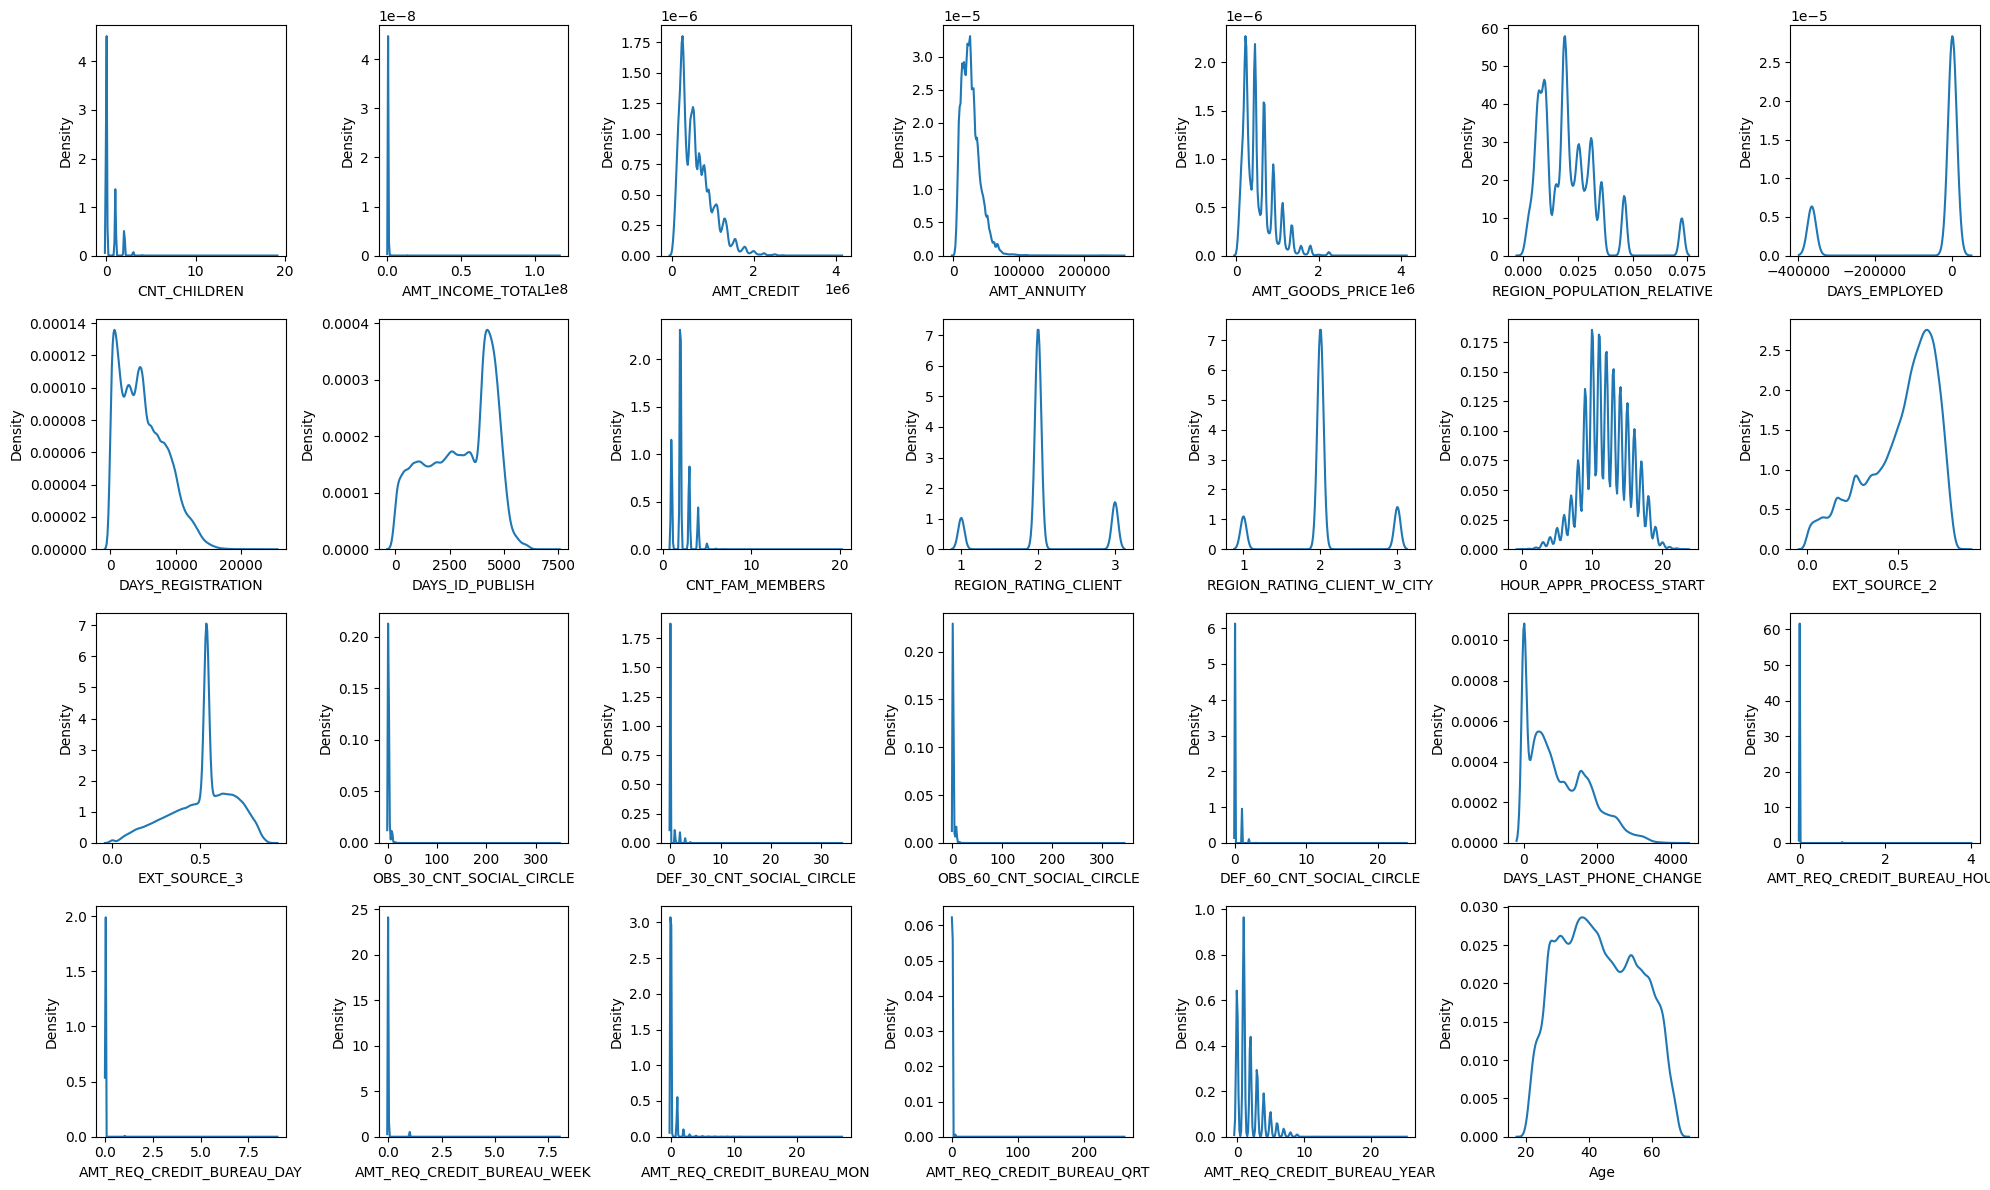

In [34]:
# Look at the distribution of data
plt.figure(figsize=(20,12))

for i, column in enumerate (num[num_a].columns, 1):
    plt.subplot(4,7,i)
    sns.kdeplot(data=num[num_a], x=num[column])
    plt.tight_layout()

The data distribution is not close to the normal distribution, so it needs to be normalized.

In [35]:
# Look for a numeric data type that has more than 2 unique values
raw_train_num = pd.DataFrame(num.nunique(), columns = ['Total_unique']).reset_index()
raw_train_num = raw_train_num.rename(columns = {'index' : 'Name_of_column'})

num_a = []
num_b = []
for i,y in enumerate(raw_train_num.Name_of_column):
    if raw_train_num['Total_unique'][i] > 2:
        num_a.append(y)
    else:
        num_b.append(y)

### Detecting outliers

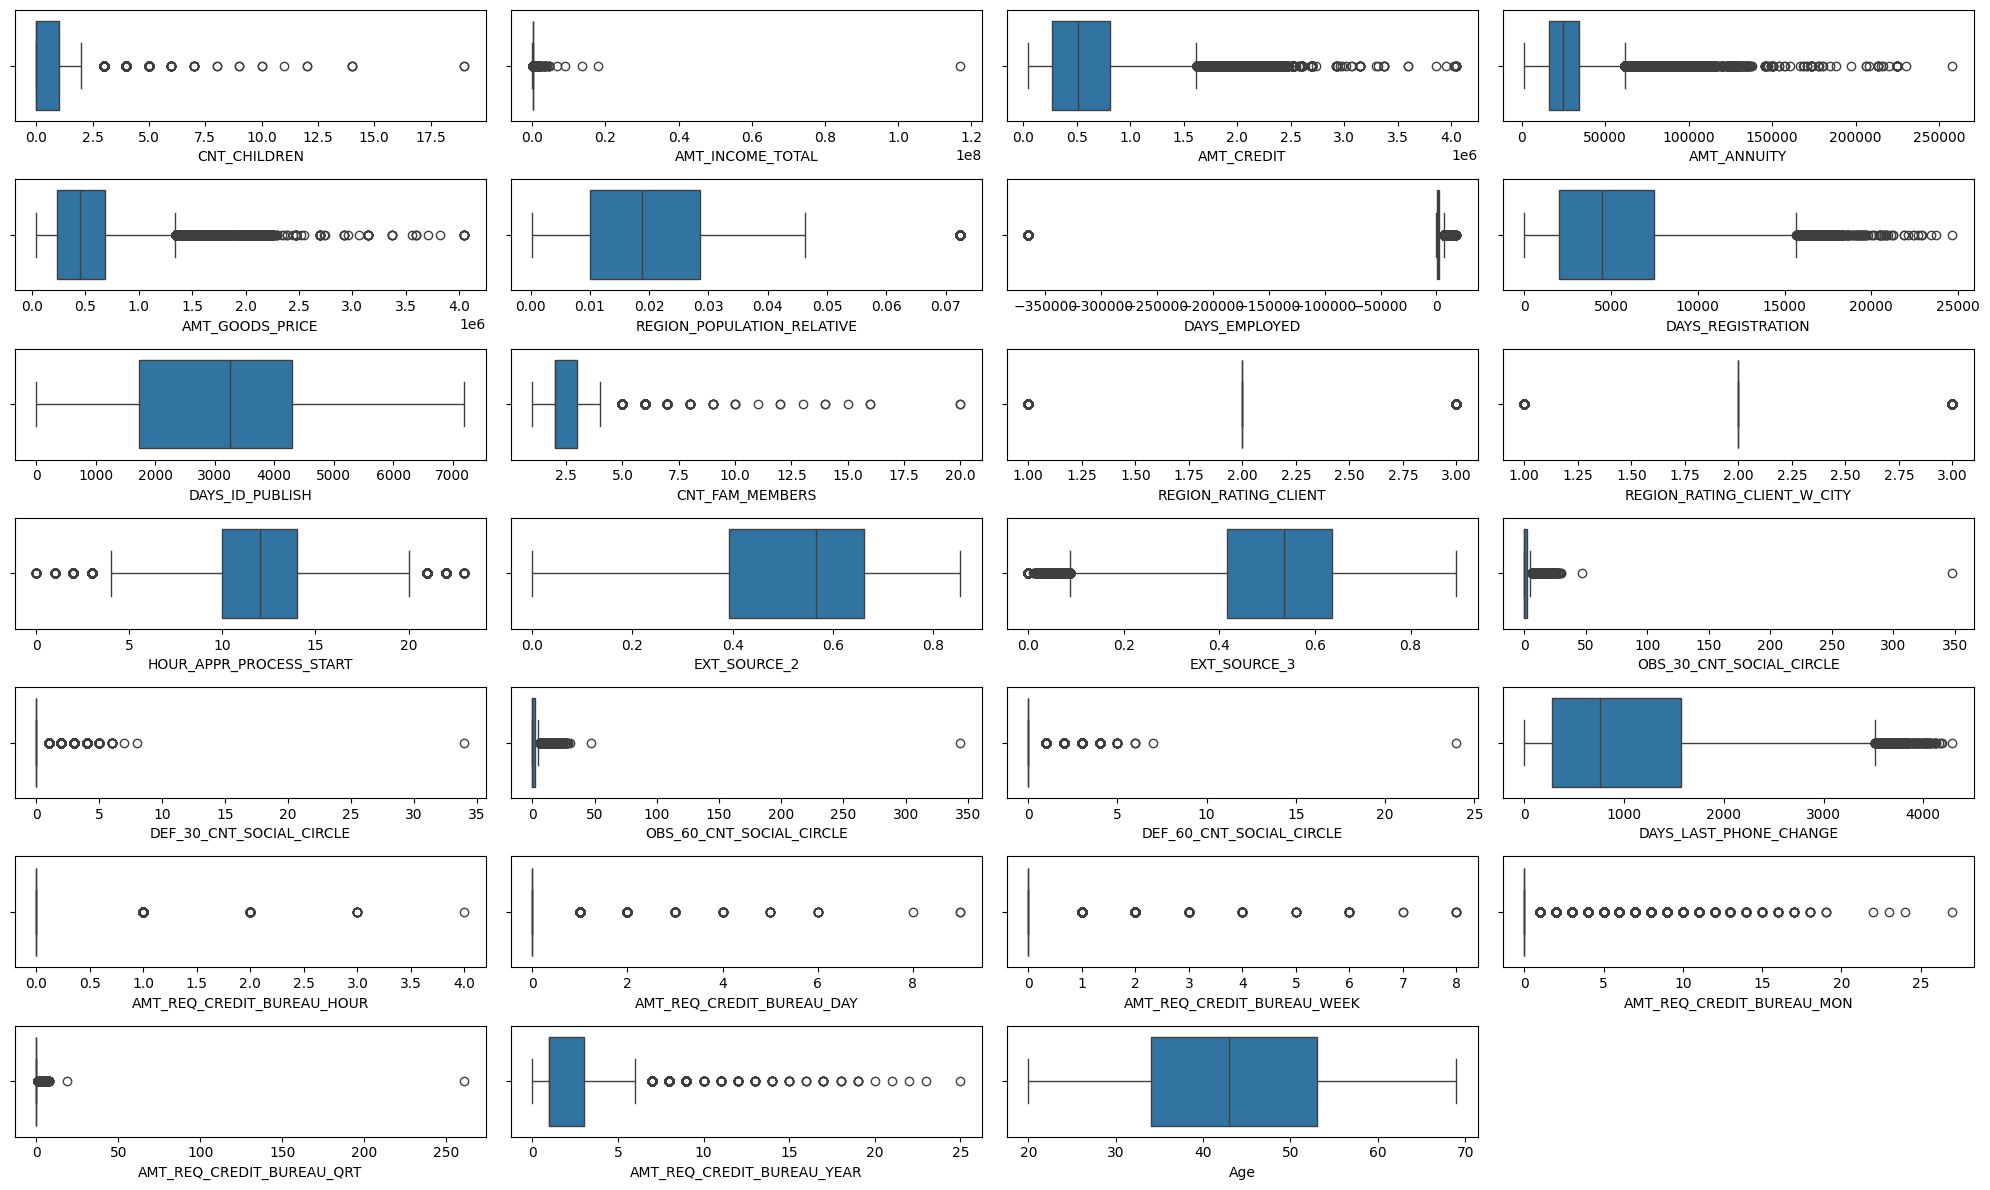

In [36]:
plt.figure(figsize=(20,12))

for i, column in enumerate (num[num_a].columns, 1):
    plt.subplot(7,4,i)
    sns.boxplot(data=num[num_a], x=num[column])
    plt.tight_layout()

The abnormal column is the CNT_CHILDREN column, so it is necessary to remove the outlier in that column.

In [37]:
# Remove outliers
print(f'Row before delete outlier at CNT_children :  {len(raw_train)}')

filtered_entries = np.array([True] * len(raw_train))

zscore = abs(stats.zscore(raw_train['CNT_CHILDREN'])) # calculate z-score absolute
filtered_entries = (zscore < 3) & filtered_entries # keep that z-score absolute  less than 3

raw_train = raw_train[filtered_entries] # filter

print(f'Row after delete outlier at CNT_children : {len(raw_train)}')

Row before delete outlier at CNT_children :  307511
Row after delete outlier at CNT_children : 303239


### Feature transformation

In [38]:
x = raw_train.drop(columns = 'TARGET', axis=1)
num = x[num_a]

In [39]:
num_mean = num.mean()
num_std = num.std()

num = (num - num_mean) / num_std
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,-0.589198,0.141631,-0.477744,-0.165346,-0.506964,-0.150759,-0.459710,0.385831,0.577304,-1.320962,-0.101497,-0.061058,-0.632857,-1.320400,-2.155754,0.243323,4.164731,0.252564,5.254914,-0.206172,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,-1.544674
1,-0.589198,0.424753,1.725509,0.594213,1.600729,-1.253789,-0.463592,1.083617,1.789288,-0.131831,-2.066499,-2.051288,-0.326703,0.562965,0.110575,-0.173588,-0.320453,-0.168056,-0.275683,0.163731,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.122835
2,-0.589198,-0.424615,-1.152447,-1.405069,-1.091757,-0.784603,-0.456807,0.212377,0.304955,-1.320962,-0.101497,-0.061058,-0.939011,0.215257,1.222789,-0.590499,-0.320453,-0.588676,-0.275683,0.179446,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.706463
3,-0.589198,-0.141492,-0.711048,0.179004,-0.653162,-0.930108,-0.476632,-1.367137,0.367244,-0.131831,-0.101497,-0.061058,1.510219,0.710763,0.110575,0.243323,-0.320453,0.252564,-0.275683,0.418795,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,0.706463
4,-0.589198,-0.198116,-0.213418,-0.361141,-0.068369,0.562091,-0.476625,0.197922,-0.309320,-1.320962,-0.101497,-0.061058,-0.326703,-1.006994,0.110575,-0.590499,-0.320453,-0.588676,-0.275683,-0.172324,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.873213


In [40]:
num_1 = x[num_b]
num_1 = num_1.loc[~num_1.index.duplicated(keep='first')]

num = pd.concat([num, num_1], axis=1)
num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,-0.589198,0.141631,-0.477744,-0.165346,-0.506964,-0.150759,-0.459710,0.385831,0.577304,-1.320962,-0.101497,-0.061058,-0.632857,-1.320400,-2.155754,0.243323,4.164731,0.252564,5.254914,-0.206172,-0.071110,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,-1.544674,1,1,0,1,1,0,0,0,0,0,0,0
1,-0.589198,0.424753,1.725509,0.594213,1.600729,-1.253789,-0.463592,1.083617,1.789288,-0.131831,-2.066499,-2.051288,-0.326703,0.562965,0.110575,-0.173588,-0.320453,-0.168056,-0.275683,0.163731,-0.071110,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.122835,1,1,0,1,1,0,0,0,0,0,0,0
2,-0.589198,-0.424615,-1.152447,-1.405069,-1.091757,-0.784603,-0.456807,0.212377,0.304955,-1.320962,-0.101497,-0.061058,-0.939011,0.215257,1.222789,-0.590499,-0.320453,-0.588676,-0.275683,0.179446,-0.071110,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.706463,1,1,1,1,1,0,0,0,0,0,0,0
3,-0.589198,-0.141492,-0.711048,0.179004,-0.653162,-0.930108,-0.476632,-1.367137,0.367244,-0.131831,-0.101497,-0.061058,1.510219,0.710763,0.110575,0.243323,-0.320453,0.252564,-0.275683,0.418795,-0.071110,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,0.706463,1,1,0,1,0,0,0,0,0,0,0,0
4,-0.589198,-0.198116,-0.213418,-0.361141,-0.068369,0.562091,-0.476625,0.197922,-0.309320,-1.320962,-0.101497,-0.061058,-0.326703,-1.006994,0.110575,-0.590499,-0.320453,-0.588676,-0.275683,-0.172324,-0.071110,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.873213,1,1,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,-0.589198,-0.047118,-0.855088,0.032003,-0.848093,0.843848,-0.456884,-0.976864,0.668749,-1.320962,-2.066499,-2.051288,0.897911,0.874258,0.110575,-0.590499,-0.320453,-0.588676,-0.275683,0.834634,-0.071110,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,-1.544674,1,1,0,1,0,0,0,0,0,0,0,0
307507,-0.589198,-0.405740,-0.818198,-1.042382,-0.848093,0.309175,2.118014,0.176098,-0.728114,-1.320962,-0.101497,-0.061058,-1.245164,-2.090717,0.110575,-0.590499,-0.320453,-0.588676,-0.275683,1.164645,-0.071110,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,1.039964,1,0,0,1,1,0,0,0,0,0,0,0
307508,-0.589198,-0.065993,0.195641,0.199205,0.126562,-1.148184,-0.511027,-0.489661,-1.430522,-1.320962,1.863505,1.929173,-0.939011,0.109423,-1.700753,1.910966,-0.320453,1.935046,-0.275683,-1.143018,12.726059,-0.058754,-0.155798,0.893665,-0.307919,-0.441070,-0.210667,1,1,0,1,0,1,0,0,0,0,1,1
307509,-0.589198,0.009507,-0.568393,-0.475821,-0.592246,-1.125704,-0.488940,0.693628,1.365193,-0.131831,-0.101497,-0.061058,-0.939011,-0.003584,0.830414,-0.590499,-0.320453,-0.588676,-0.275683,0.775401,-0.071110,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,-0.961046,1,1,0,1,0,0,0,0,0,1,1,0


## Object data types

In [41]:
obj = x.select_dtypes(include='object')
raw_train_obj = pd.DataFrame(obj.nunique(), columns = ['Total_unique']).reset_index()
raw_train_obj = raw_train_obj.rename(columns = {'index' : 'Name_of_column'})

obj_1 = []
obj_2 = []
for i,y in enumerate(raw_train_obj.Name_of_column):
    if raw_train_obj['Total_unique'][i] > 2:
        obj_1.append(y)
    else:
        obj_2.append(y)
obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,Marital_status,Age_category
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Unmarried,Young Adult
1,Cash loans,F,N,N,Family,State servant,Higher education,House / apartment,Core staff,MONDAY,School,Married,Adult
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,MONDAY,Government,Unmarried,Older
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Married,Older
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Core staff,THURSDAY,Religion,Unmarried,Older
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,With parents,Sales staff,THURSDAY,Services,Unmarried,Young Adult
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,House / apartment,Laborers,MONDAY,Business Entity Type 3,Unmarried,Older
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,House / apartment,Managers,THURSDAY,School,Unmarried,Adult
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,Married,Young Adult


### One hot encoding

In [42]:
for cat in obj_1:
    onehots = pd.get_dummies(obj[cat], prefix=cat)
    obj = obj.join(onehots)

obj = obj.drop(columns = obj_1)

### Label encoding

In [43]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
for cat in obj_2:
    obj[cat]= label_encoder.fit_transform(obj[cat])

obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,Marital_status,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,Age_category_Adult,Age_category_Older,Age_category_Young Adult
0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [44]:
df_train = pd.concat([num, obj], axis=1)

In [45]:
df = pd.concat([df_train, raw_train['TARGET']],axis=1)

In [46]:
df

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,Marital_status,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_T

## Split data

In [47]:
x = df.drop(columns = 'TARGET')
y = df['TARGET']

## Oversampling

In [48]:
sm = SMOTE(random_state = 2)
x_over, y_over = sm.fit_resample(x, y.values.ravel())

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.3, random_state=25)

# Machine Learning Implementation and Evaluation

## Logistic Regression

In [50]:
def confusionmatrix(predictions, y_test):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return disp.plot()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.90      0.99      0.94     83753
           1       0.99      0.88      0.94     83553

    accuracy                           0.94    167306
   macro avg       0.95      0.94      0.94    167306
weighted avg       0.95      0.94      0.94    167306



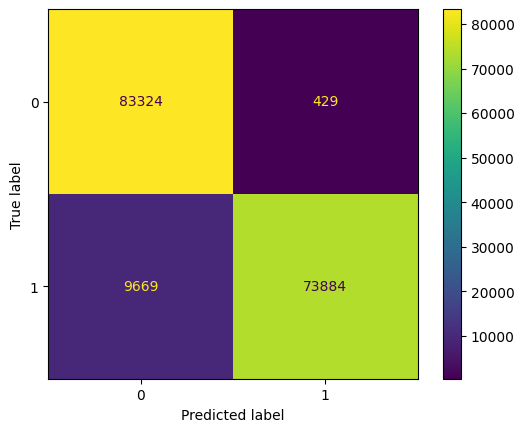

In [51]:
lr = LogisticRegression()
lr.fit(x_train, y_train.ravel())
predictions = lr.predict(x_test)

# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       0.90      1.00      0.94    195090
           1       0.99      0.89      0.94    195290

    accuracy                           0.94    390380
   macro avg       0.95      0.94      0.94    390380
weighted avg       0.95      0.94      0.94    390380



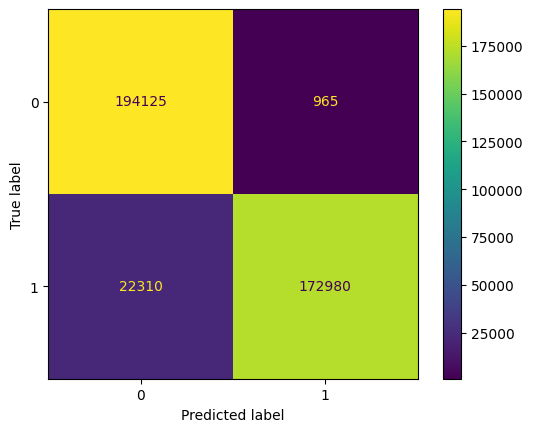

In [52]:
predictions = lr.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

## XGBoost

              precision    recall  f1-score   support

           0       0.92      1.00      0.95     83753
           1       0.99      0.91      0.95     83553

    accuracy                           0.95    167306
   macro avg       0.96      0.95      0.95    167306
weighted avg       0.96      0.95      0.95    167306



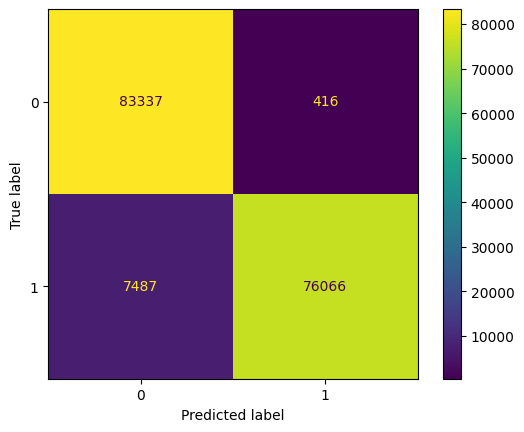

In [53]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=25)
xgb_model.fit(x_train, y_train.ravel())

predictions = xgb_model.predict(x_test)

# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    195090
           1       1.00      0.91      0.95    195290

    accuracy                           0.96    390380
   macro avg       0.96      0.96      0.96    390380
weighted avg       0.96      0.96      0.96    390380



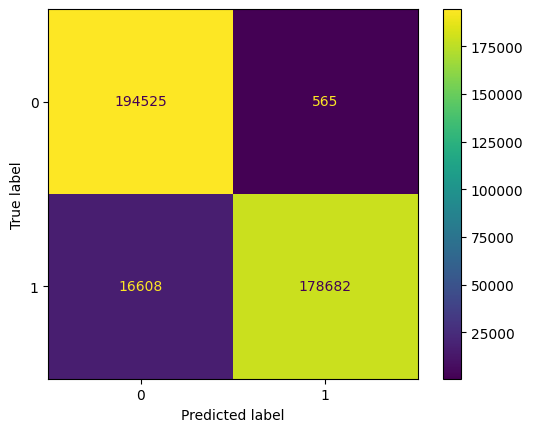

In [54]:
predictions = xgb_model.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

## Random Forest

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     83753
           1       0.99      0.92      0.95     83553

    accuracy                           0.96    167306
   macro avg       0.96      0.96      0.96    167306
weighted avg       0.96      0.96      0.96    167306



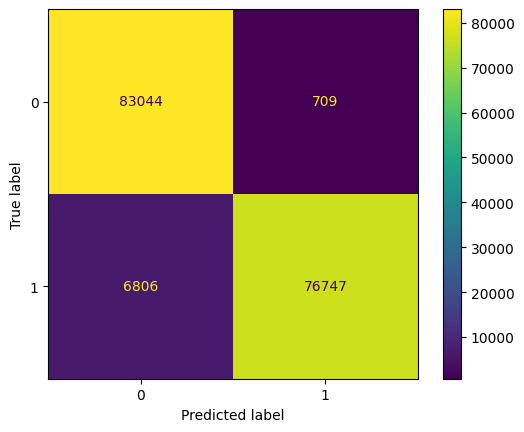

In [55]:
rf_model = RandomForestClassifier().fit(x_train, y_train)
predictions = rf_model.predict(x_test)

# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    195090
           1       1.00      1.00      1.00    195290

    accuracy                           1.00    390380
   macro avg       1.00      1.00      1.00    390380
weighted avg       1.00      1.00      1.00    390380



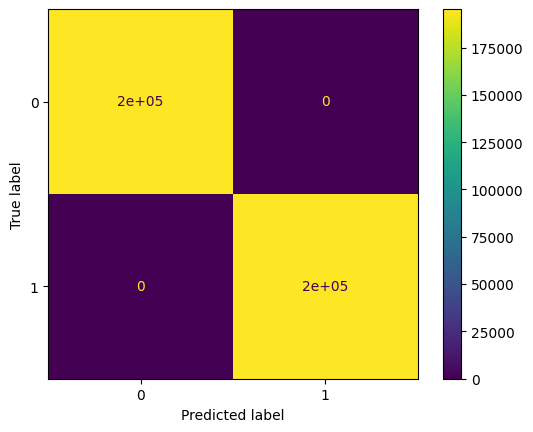

In [56]:
predictions = rf_model.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

# Business Recommendation



1.   Home Credit Indonesia can target the Adult category for loans because Adult age category (36-50 years old) has the most loan applications with no repayment issues.
2.   Home Credit Indonesia should focus on creating campaigns for HR staff, IT staff and Realty agents as there are less than a thousand customers applying for loans. Yet, they have a good track record of repaying their loans without any problems.
3.   Random Forest is the best machine learning model that can be used to determine whether or not a customer will have problems making loan payments.

